In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

In [2]:
adult = pd.read_csv("./adult/adult.data", header=None)#, index_col=0)

In [3]:
adult.columns = ["age", "workClass", "fnlwgt", "education", "education-num","marital-status", "occupation", "relationship",
          "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

In [4]:
adult.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Viz 1 and 2

#### Viz 1

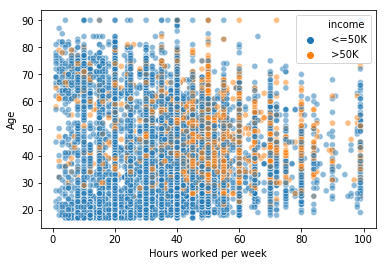

In [5]:
sns.scatterplot(x=adult['hours-per-week'], y=adult['age'], hue=adult['income'], alpha=0.5)
plt.xlabel('Hours worked per week')
plt.ylabel('Age')
plt.show()

For the above, the task of the user would be to explore the tread in age and hours per week. This falls under analyse and consume (slide 21 of tasks).
I use a scatterplot for this task, where the marks are points and channels encoded are: (slide 44 of marks and channels)
* position x for hours-per-week
* position y for age
* color for income

Using points with poisiton channels are the most effective for numeric data. I encode the income with color to make income with >50k stand out in the plot.


From this viz, I can see that there most people who earn more than 50k generally work more than 40 hrs. I could hours-per-week to <=40 and >40 to simplify the data, helping with overfitting (if that would be a problem).

#### Viz 2

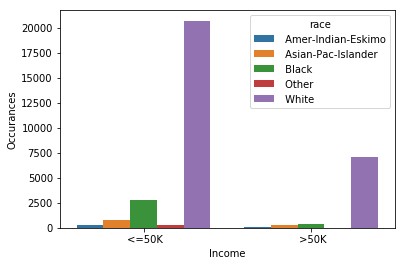

In [6]:
counts = adult.groupby(['income', 'race']).size().reset_index()
counts.columns = ['income', 'race', 'count']
sns.barplot(x='income', y='count', hue='race', data=counts)
plt.xlabel('Income')
plt.ylabel('Occurances')
plt.show()

For Viz 2, the task still remain to explore relations. Here I try to see if the race has any affect on the income of an individual.
I use barplots for this where the marks are lines and channels are: (slide 44 of marks and channels)
* height for the # of time a combination occurs in the data
* color of bar to indicate the race

I find this most effective as the heights easy to compare.

From this graph, I see that a majority of the population in White. This will cause bias in the model. We could use a resampling technique to alliviate this.


## KNN

In [7]:
n_features = adult.shape[1]
#education is a string representation of education-num; drop education-num
adult = adult.drop(columns=["education-num"])

In [8]:
categorical_var = adult.select_dtypes(include='object')
cat_cols = categorical_var.columns[0:8]

In [9]:
#replace unknowns(" ?") by the most frequent category of the attribute
for i in cat_cols:
    col = adult.loc[:,i]
    print(i, " has", col[col == ' ?'].shape[0], " unknowns. Max value of col: ", col.value_counts().idxmax())
    col[col == ' ?'] = col.value_counts().idxmax()

workClass  has 1836  unknowns. Max value of col:   Private
education  has 0  unknowns. Max value of col:   HS-grad
marital-status  has 0  unknowns. Max value of col:   Married-civ-spouse
occupation  has 1843  unknowns. Max value of col:   Prof-specialty
relationship  has 0  unknowns. Max value of col:   Husband


/home/nischal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


race  has 0  unknowns. Max value of col:   White
sex  has 0  unknowns. Max value of col:   Male
native-country  has 583  unknowns. Max value of col:   United-States


In [10]:
#creating dummy variables
dummy_var = pd.get_dummies(adult[cat_cols])
adult = adult.drop(columns=cat_cols)
data = pd.concat([adult, dummy_var], axis = 1)

In [11]:
y_classes = data.income.unique()
data.income = [0 if data.income[i]==y_classes[0] else 1 for i in range(data.shape[0])]

In [12]:
train = data.sample(frac=0.8, random_state = 101)
test = data.drop(train.index)

In [13]:
scaler = StandardScaler()
train.iloc[:,0:5] = scaler.fit_transform(train.iloc[:,0:5])

/home/nischal/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/nischal/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [14]:
test.iloc[:, 0:5] = scaler.transform(test.iloc[:, 0:5])

/home/nischal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [16]:
X = train.loc[:, train.columns!='income']
y = train.income

In [49]:
knn = KNeighborsClassifier()
scoring = {'Accuracy': make_scorer(accuracy_score)}
param_grid = {"n_neighbors": np.arange(1, 11),
             "p": [1,2]}
grid_search = GridSearchCV(knn, param_grid = param_grid, cv=10, refit = False, scoring=scoring, n_jobs=7, verbose=10)

grid_search.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:   37.2s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:  1.3min
/home/nischal/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:  1.8min
/home/nischal/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  3.7min
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:  6.5min
/home/

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=7,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), 'p': [1, 2]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring={'Accuracy': make_scorer(accuracy_score)}, verbose=10)

In [315]:
scores = pd.DataFrame(grid_search.cv_results_)
test_acc = scores[scores.param_p == 2].iloc[:, 7:17]
test_acc.index = test_acc.reset_index().index + 1 

/home/nischal/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_Accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/nischal/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_Accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/nischal/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_Accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/nischal/anaco

## Viz 3

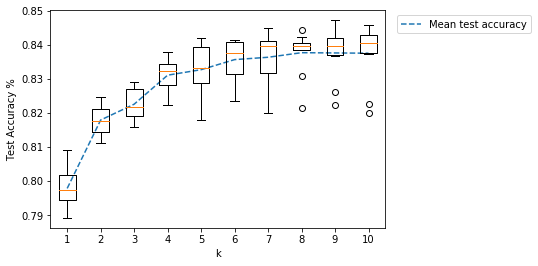

In [324]:
plt.plot(np.arange(1, 11), scores[scores.param_p == 2].mean_test_Accuracy, '--', label="Mean test accuracy")
plt.boxplot(test_acc)
plt.legend(loc=1, bbox_to_anchor=(1.45,1))
plt.xlabel('k')
plt.ylabel('Test Accuracy %')
plt.show()

The task for this visualization is query and summarise (slide 21 in tasks), user would want to see the statistics of the 10 models doe each fit. 
I use a boxplot for this task we want to show the distribution of the scores for each k. This would allow the user to see which models would have a higher variance. Boxplots juxtaposed will make it easier to compare. I also add a line to show the mean accuracies across k.
Boxplots use lines and points for makes and position and heights for channels. (slide 44 of marks and channels). 

From this visualizaion, I can see that as k increase, the test accuracy also increases. A good model to pick would be for k=8, which has a very low IRQ, making it a good fit. Others would be k=10 and k=9 (in that order).

### Refit for optimal

In [20]:
test_X = test.loc[:, test.columns!='income']
test_y = test.income

In [22]:
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

In [23]:
model.score(test_X, test_y)

0.8424447174447175

The model with k=9 give an accuracy of 84% on the test set.